# Seance 1 : Introduction to protein alignment

In [1]:
import Bio
import numpy as np
import pandas as pd
from Bio import SeqIO

## 1.1 Introduction Needleman-Wunsch algorithm 

In [28]:
#Algorithme qui renvoie l'algorothme de Needleman-Wunsch pour l'alignement global de deux sequences d'ADN
def matrix_needleman_wunsch(seq1, seq2, identity_score, substitution_score, gap_penalty):
    """Implémente l'algorithme de Needleman-Wunsch pour l'alignement global de deux séquences"""
    # Initialisation de la matrice
    n = len(seq1)
    m = len(seq2)
    score_matrix = np.zeros((n+1, m+1), dtype=int)
    backtrack_matrix = [[[] for _ in range(m+1)] for _ in range(n+1)]

    # Remplissage de la première ligne et de la première colonne
    for i in range(n):
        score_matrix[i][0] = gap_penalty * i
    for j in range(m):
        score_matrix[0][j] = gap_penalty * j

    for i in range(1, n+1):
        backtrack_matrix[i][0] = [1]  # UP

    for j in range(1, m+1):
        backtrack_matrix[0][j] = [2]  # LEFT

    # Remplissage de la matrice
    for i in range(1, n+1):
        for j in range(1, m+1):
            if seq1[i-1] == seq2[j-1]:
                score = identity_score
            else:
                score = substitution_score
            match = score_matrix[i-1][j-1] + score
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty

            # Mettre tous les maximums dans la matrice de retour en arrière
            score_matrix[i][j] = max(match, delete, insert)
            if score_matrix[i][j] == match:
                backtrack_matrix[i][j].append(0)  # Diagonal
            if score_matrix[i][j] == delete:
                backtrack_matrix[i][j].append(1)  # Up
            if score_matrix[i][j] == insert:
                backtrack_matrix[i][j].append(2)  # Left
        
    return score_matrix, backtrack_matrix

def score_alignment(score_matrix):
    """Retourne le score de l'alignement optimal"""
    return score_matrix[-1][-1]

def optimal_alignment_Needleman(seq1, seq2, backtrack_matrix):
    """Retourne toutes les séquences alignées optimales"""
    i, j = len(seq1), len(seq2)
    a1, a2 = "", ""

    while i > 0 or j > 0:
        direction = backtrack_matrix[i][j][0]

        if direction == 0:  # diagonal
            a1 += seq1[i-1]
            a2 += seq2[j-1]
            i -= 1
            j -= 1
        elif direction == 1:  # up
            a1 += seq1[i-1]
            a2 += "-"
            i -= 1
        else:  # left
            a1 += "-"
            a2 += seq2[j-1]
            j -= 1

    return a1[::-1], a2[::-1]

    

def Needleman_wunsch(seq1, seq2, identity_score, substitution_score, gap_penalty):
    """Fonction principale pour exécuter l'algorithme de Needleman-Wunsch"""
    score_matrix, backtrack_matrix = matrix_needleman_wunsch(seq1, seq2, identity_score, substitution_score, gap_penalty)
    score = score_alignment(score_matrix)
    aligned_seq1, aligned_seq2 = optimal_alignment_Needleman(seq1, seq2, backtrack_matrix)
    
    return score, aligned_seq1, aligned_seq2

## Test 1 Needleman

In [26]:
#Test de l'algorithme avec des séquences d'exemple
seq1 = "CHAT"
seq2 = "CAT"

identity_score_test = 1
substitution_score_test = -1
gap_penalty_test = -2


In [ ]:
score_test, aligned_seq1_test, aligned_seq2_test = Needleman_wunsch(seq1, seq2, identity_score_test, substitution_score_test, gap_penalty_test)

In [30]:
print("Score de l'alignement :", score_test)
print("Séquence 1 alignée :", aligned_seq1_test)
print("Séquence 2 alignée :", aligned_seq2_test)

Score de l'alignement : 1
Séquence 1 alignée : CHAT
Séquence 2 alignée : C-AT


## 1.2 Algorithme de Needleman-Wunsch, avec BLOSUM62

In [41]:
# Chargement de la matrice BLOSUM62 depuis un fichier texte

def load_blosum(filename):
    """
    Load a substitution matrix (e.g. BLOSUM) from a file.

    Returns:
        dict: {(aa1, aa2): score}
    """
    matrix = {}

    with open(filename) as f:
        lines = f.readlines()

    # Ignore comments
    lines = [line.strip() for line in lines if line.strip() and not line.startswith("#")]

    # First non-comment line = column headers
    headers = lines[0].split()

    # Remaining lines = rows
    for line in lines[1:]:
        parts = line.split()
        row_aa = parts[0]
        scores = parts[1:]

        for col_aa, score in zip(headers, scores):
            matrix[(row_aa, col_aa)] = int(score)

    return matrix

In [42]:
blosum = load_blosum("blosum62.txt")

print(blosum[("A", "A")])  # 4
print(blosum[("A", "G")])  # 0
print(blosum[("W", "W")])  # 11

4
0
11


In [66]:
def matrix_needleman_wunsch_blosum(seq1, seq2, blosum, gap_penalty):
    n = len(seq1)
    m = len(seq2)

    score_matrix = np.zeros((n+1, m+1), dtype=int)
    backtrack_matrix = [[[] for _ in range(m+1)] for _ in range(n+1)]

    # Initialisation
    for i in range(n+1):
        score_matrix[i][0] = gap_penalty * i
        if i > 0:
            backtrack_matrix[i][0] = [1]  # UP

    for j in range(m+1):
        score_matrix[0][j] = gap_penalty * j
        if j > 0:
            backtrack_matrix[0][j] = [2]  # LEFT

    # Remplissage
    for i in range(1, n+1):
        for j in range(1, m+1):

            aa = seq1[i-1]
            bb = seq2[j-1]

            match = score_matrix[i-1][j-1] + blosum[(aa, bb)]
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty

            score_matrix[i][j] = max(match, delete, insert)

            if score_matrix[i][j] == match:
                backtrack_matrix[i][j].append(0)
            if score_matrix[i][j] == delete:
                backtrack_matrix[i][j].append(1)
            if score_matrix[i][j] == insert:
                backtrack_matrix[i][j].append(2)

    return score_matrix, backtrack_matrix

def Needleman_wunsch_blosum(seq1, seq2, blosum, gap_penalty):
    score_matrix, backtrack_matrix = matrix_needleman_wunsch_blosum(
        seq1, seq2, blosum, gap_penalty
    )

    score = score_alignment(score_matrix)
    aligned_seq1, aligned_seq2 = optimal_alignment_Needleman(
        seq1, seq2, backtrack_matrix
    )

    return score, score_matrix, aligned_seq1, aligned_seq2

## Test 2 Needleman Blossum

In [56]:
#Test de l'algorithme avec des séquences d'exemple
seq1 = "CAT"
seq2 = "HER"

gap_penalty_test = -8

In [ ]:
score_test, score_matrix_test, aligned_seq1_test, aligned_seq2_test = Needleman_wunsch_blosum(seq1, seq2, blosum, gap_penalty_test)
print("Score de l'alignement :", score_test)
print("Séquence 1 alignée :", aligned_seq1_test)
print("Séquence 2 alignée :", aligned_seq2_test)
print("Matrice", score_matrix_test)

Score de l'alignement : -5
Séquence 1 alignée : CAT
Séquence 2 alignée : HER
Matrice [[  0  -8 -16 -24]
 [ -8  -3 -11 -19]
 [-16 -10  -4 -12]
 [-24 -18 -11  -5]]


# Seance 2: Alignement de N séquences

## Chargement des séquences à aligner

In [39]:
records = list(SeqIO.parse("orthologs.fasta", "fasta"))
print(len(records))

8


In [40]:
for record in records:
    print("ID :", record.id)
    print("Name :", record.name)
    print("Description :", record.description)
    print("Sequence :", str(record.seq))
    print()

ID : goshawk
Name : goshawk
Description : goshawk
Sequence : MVLSANDKTNVKNVFTKIGGHAEEYGAETLERMFTTYPPTKTYFPHFDLHHGSAQIKAHGKKVVGALIEAVNHIDDIAGALSKLSDLHAQKLRVDPVNFKLLGQCFLVVVAIHHPSVLTPEVHASLDKFLCAVGNVLTAKYR

ID : vulture
Name : vulture
Description : vulture
Sequence : MVLSANDKTNVKTVFTKITGHAEDYGAETLERMFITYPPTKTYFPHFDLHHGSAQIKAHGKKVVGALIEAVNHIDDIAGALSKLSDLHAQKLRVDPVNFKLLGQCFLVVVAIHHPSVLTPEVHASLDKFLCAVGNVLTAKYR

ID : lesser
Name : lesser
Description : lesser panda
Sequence : MVLSPADKTNVKSTWDKLGGHAGEYGGEALERTFASFPTTKTYFPHFDLSPGSAQVKAHGKKVADALTLAVGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLACHHPAEFTPAVHASLDKFFSAVSTVLTSKYR

ID : giant
Name : giant
Description : giant panda
Sequence : MVLSPADKTNVKATWDKIGGHAGEYGGEALERTFASFPTTKTYFPHFDLSPGSAQVKAHGKKVADALTTAVGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPAEFTPAVHASLDKFFSAVSTVLTSKYR

ID : moose
Name : moose
Description : moose
Sequence : MVLSATDKSNVKAAWGKVGGNAPAYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKAHGEKVANALTKAVGHLDDLPGTLSDLSDLHAHKLRVDPVNFKLLSHTLLVTLAAHLPSDFTPAV

In [ ]:
from Bio.Cluster import *

./bali_score.py RV11.aligned/BB11001.fasta ~/uniprot.fasta
python3 bali_score.py RV11.aligned/BB11001.fasta uniprot.fasta
Pour comparer les séquences d'alignement avec le fichier téléchargé de uniprot.

## Needleman Wunsch par bloc

In [ ]:
def matrix_needleman_profile_alignment(seqs, seqs_to_align, gap_penalty):
    """Return matrix of alignment between the two blocks"""
    n = len(seqs[0])
    m = len(seqs_to_align[0])
    M = np.zeros((n+1,m+1), dtype=int)
    profile_score_matrix = np.zeros((n+1,m+1), dtype=int)
    backtrack_matrix = [[[] for _ in range(m+1)] for _ in range(n+1)]

    #Initialisation
    for i in range(1,n+1):
        M[i,0] = i*gap_penalty
        backtrack_matrix[i][0] = [1]  # UP
    for j in range(1,m+1):
        M[0,j] = j*gap_penalty
        backtrack_matrix[0][j] = [2]  # LEFT

    # Pour chaque place dans la matrice
    for i in range(1, n+1):
        for j in range(1,m+1):
            c1 = []
            c2 = []

            #Remplissage des colonnes
            for block1 in seqs:
                c1.append(block1[i-1])
            for block2 in seqs_to_align:
                c2.append(block2[j-1])
            
            profile_score_matrix[i,j] = column_alignment(c1, c2, gap_penalty)

            # Calcul M[i,j] = max(diag, up, left)
            diag = M[i-1,j-1] + profile_score_matrix[i,j]
            up   = M[i-1,j] + gap_penalty
            left = M[i,j-1] + gap_penalty

            M[i,j] = max(diag, up, left)

            if M[i,j] == diag:
                backtrack_matrix[i][j].append(0)  # Diagonal
            if M[i,j] == up:
                backtrack_matrix[i][j].append(1)  # Up
            if M[i,j] == left:
                backtrack_matrix[i][j].append(2)  # Left
    
    return M, backtrack_matrix

def backtrack_profile(seqs, seqs_to_align, M, backtrack_matrix):
    """Retourne les deux blocks de séquences alignés selon la matrice de backtrack"""
    n = len(seqs[0])
    m = len(seqs_to_align[0])

    aseqs = ['' for _ in seqs]
    aseqs_to_align = ['' for _ in seqs_to_align]

    i, j = n, m
    while i > 0 or j > 0:
        direction = backtrack_matrix[i][j][0]

        if direction == 0:  # Diagonal
            for idx, seq in enumerate(seqs):
                aseqs[idx] = seq[i-1] + aseqs[idx]
            for idx, seq in enumerate(seqs_to_align):
                aseqs_to_align[idx] = seq[j-1] + aseqs_to_align[idx]
            i -= 1
            j -= 1
        elif direction == 1:  # Up
            for idx, seq in enumerate(seqs):
                aseqs[idx] = seq[i-1] + aseqs[idx]
            for idx in range(len(seqs_to_align)):
                aseqs_to_align[idx] = '-' + aseqs_to_align[idx]
            i -= 1
        else:  # Left
            for idx in range(len(seqs)):
                aseqs[idx] = '-' + aseqs[idx]
            for idx, seq in enumerate(seqs_to_align):
                aseqs_to_align[idx] = seq[j-1] + aseqs_to_align[idx]
            j -= 1

    return aseqs, aseqs_to_align

def column_alignment(c1, c2, gap_penalty):
    """Compare une colonne des deux blocks et renvoie la moyenne du score calculé nxm"""
    n = len(c1)
    m = len(c2)
    M = np.zeros((n,m))

    for i in range(n):
        for j in range(m):
            a = c1[i]
            b = c2[j]
            #Si il y a un gap
            if a == '-' or b == '-':
                M[i,j] = gap_penalty
            else:
                #Si pas de gap
                M[i,j] = blosum[(a, b)]
    
    return np.sum(M)/(n*m)

In [83]:
seq1 = ["C-AT", "CHAT"]
seq2 = ["HER"]
gap_penalty_test = -8

# Remplissage de la matrice de score et de backtrack
M, backtrack_matrix = matrix_needleman_profile_alignment(seq2, seq1, gap_penalty_test)

# Backtrack pour obtenir les alignements
aligned_seq1, aligned_seq2 = backtrack_profile(seq2, seq1, M, backtrack_matrix)

# Affichage
print("Aligned seq1:")
for s in aligned_seq1:
    print(s)
print("\nAligned seq2:")
for s in aligned_seq2:
    print(s)

# Score final
print("\nScore d'alignement:", score_alignment(M))

#Matrice
print(M)

Aligned seq1:
-HER

Aligned seq2:
C-AT
CHAT

Score d'alignement: -10
[[  0  -8 -16 -24 -32]
 [ -8  -3  -8 -16 -24]
 [-16 -11  -7  -9 -17]
 [-24 -19 -15  -8 -10]]


## Matrice de distance

In [94]:
def matrix_distance(seq, gap_penalty, blosum):
    """Renvoie la matrice de distance avec les scores obtenus avec l'algorithme de Needleman Wunsch Blosum"""
    n = len(seq)
    M = np.zeros((n,n), dtype=int)
    for i in range(n):
        for j in range(i, n):
            score_matrix = matrix_needleman_wunsch_blosum(seq[i],seq[j],blosum,gap_penalty)[0]
            M[i,j] = score_alignment(score_matrix)
            M[j,i] = score_alignment(score_matrix)
    
    return M

In [95]:
seq1 = ["CAT", "CHAT"]
seq2 = ["HER"]
gap_penalty_test = -8

print(matrix_distance(seq1 + seq2, gap_penalty_test, blosum))

[[18 10 -5]
 [10 26 -2]
 [-5 -2 18]]


## Algorithme UPGMA

In [58]:
class Node:
    def __init__(self, name=None, left=None, right=None, height=0.0, size=1):
        """
        A node in a UPGMA tree
        """
        self.name = name        # label for leaves
        self.left = left
        self.right = right
        self.height = height    # height of the node
        self.size = size        # number of leaves under this node

    def is_leaf(self):
        return self.left is None and self.right is None

    def __repr__(self):
        if self.is_leaf():
            return self.name
        return f"({self.left},{self.right})"

In [84]:
# Algorithme UPGMA

class UPGMA:
    def __init__(self, labels, distance_matrix):
        """
        labels: list of taxon names
        distance_matrix: numpy array (NxN)
        """
        self.labels = labels
        self.D = distance_matrix.astype(float)

        # Initial clusters
        self.clusters = {
            i: Node(name=labels[i]) for i in range(len(labels))
        }

    def find_closest_clusters(self):
        """Return indices (i, j) of closest clusters"""
        min_dist = float("inf")
        pair = None

        for i in self.clusters:
            for j in self.clusters:
                if i < j and self.D[i, j] < min_dist:
                    min_dist = self.D[i, j]
                    pair = (i, j)

        return pair, min_dist

    def merge_clusters(self, i, j, dist):
        ci = self.clusters[i]
        cj = self.clusters[j]

        new_node = Node(left=ci, right=cj, height=dist/2, size=ci.size + cj.size)

        new_index = max(self.clusters) + 1

        # Créer une nouvelle matrice plus grande
        N = self.D.shape[0]
        D_new = np.zeros((N+1, N+1))
        D_new[:N, :N] = self.D

        # Calcul des distances vers les autres clusters
        for k in self.clusters:
            if k != i and k != j:
                dik = self.D[i, k]
                djk = self.D[j, k]
                D_new[new_index, k] = (ci.size * dik + cj.size * djk) / (ci.size + cj.size)
                D_new[k, new_index] = D_new[new_index, k]

        self.D = D_new
        self.clusters[new_index] = new_node

        # Supprimer les anciens clusters
        del self.clusters[i]
        del self.clusters[j]

        return new_index

    def build_tree(self):
        """Run UPGMA and return the root"""
        while len(self.clusters) > 1:
            (i, j), dist = self.find_closest_clusters()
            new_idx = self.merge_clusters(i, j, dist)

        return next(iter(self.clusters.values()))
    

In [ ]:
seq1 = ["C-AT", "CHAT"]
seq2 = ["HER"]
gap_penalty_test = -8

# Remplissage de la matrice de score et de backtrack
M, backtrack_matrix = matrix_needleman_profile_alignment(seq2, seq1, gap_penalty_test)

# Backtrack pour obtenir les alignements
aligned_seq1, aligned_seq2 = backtrack_profile(seq2, seq1, M, backtrack_matrix)

# Affichage
print("Aligned seq1:")
for s in aligned_seq1:
    print(s)
print("\nAligned seq2:")
for s in aligned_seq2:
    print(s)

# Score final
print("\nScore d'alignement:", score_alignment(M))

#Matrice
print(M)

In [99]:
seq1 = ["CAT", "CHAT"]
seq2 = ["HER"]
gap_penalty_test = -8

D = matrix_distance(seq1 + seq2, gap_penalty_test, blosum)

upgma = UPGMA(seq1 + seq2, D)
tree = upgma.build_tree()
print(tree)

(CHAT,(CAT,HER))


## Tracé de l'arbre

In [97]:
from Bio import Phylo
from Bio.Phylo.Newick import Tree, Clade

def node_to_clade(node):
    """Convert Node UPGMA en Clade Biopython pour affichage"""
    if node.name is not None:  # feuille
        return Clade(branch_length=node.height, name=node.name)
    else:
        left = node_to_clade(node.left)
        right = node_to_clade(node.right)
        return Clade(branch_length=node.height - node.left.height, clades=[left, right])

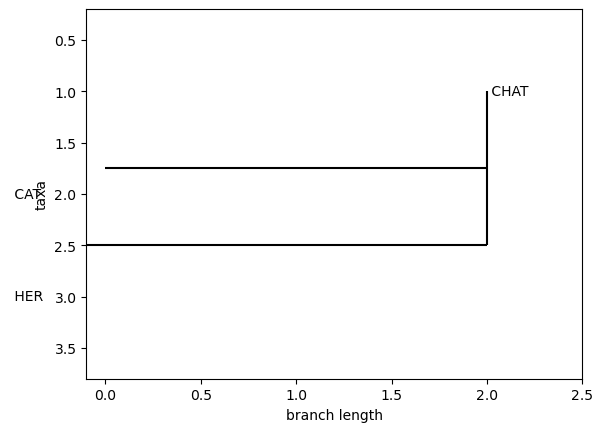

In [98]:
clade_root = node_to_clade(tree)
phylo_tree = Tree(root=clade_root)

# Tracer
Phylo.draw(phylo_tree, do_show=True)